In [121]:
from Data.medical_dataloader import ABIDELoader
from functools import partial
import einops
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [137]:
transforms = {'fmri': [partial(einops.rearrange, pattern='b h l d -> b 1 d h l'),
                           partial(F.pad, pad=(0, 0, 3, 3))]}
datahandler = ABIDELoader(
        root_dir=r"/Users/balazsmorvay/Downloads/ABIDE/data/Outputs/ccs/filt_noglobal/func_preproc",
        exp_path=r"/Users/balazsmorvay/PycharmProjects/VAE/Configurations/ABIDE_video",
        transforms=transforms,
        batch_size=1,
        num_workers=10,
        prefetch_factor=12,
        persistent_workers=True,
        rescale=True
    )
sites = ["OHSU", "SBL"]
datahandler.load_sites(site1=sites[0], site2=sites[1])

In [138]:
tr1, ts1, tr2, ts2 = datahandler.tr1.get_all_items(), datahandler.ts1.get_all_items(), datahandler.tr2.get_all_items(), datahandler.ts2.get_all_items()

In [139]:
tr1['X'].shape, ts1['X'].shape, tr2['X'].shape, ts2['X'].shape

((18, 61, 73, 61, 77),
 (4, 61, 73, 61, 77),
 (18, 61, 73, 61, 195),
 (5, 61, 73, 61, 195))

In [140]:
min_video_len = min(tr1['X'].shape[-1], ts1['X'].shape[-1])

Xt1, Xt2 = tr1['X'][..., 0:min_video_len], tr2['X'][..., 0:min_video_len]
Yt1, Yt2 = tr1['y'], tr2['y']

In [141]:
Xt1.shape, Xt2.shape

((18, 61, 73, 61, 77), (18, 61, 73, 61, 77))

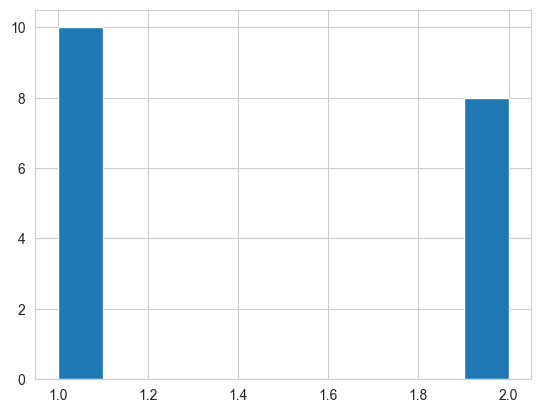

In [142]:
plt.hist(Yt1)
plt.show()

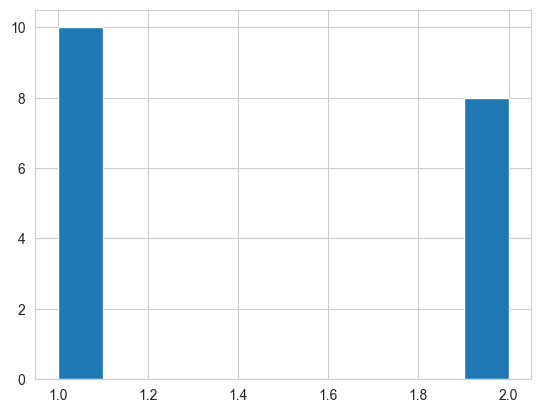

In [143]:
plt.hist(Yt2)
plt.show()

At this point, we have two datasets with the same amount of data, with the same label distribution

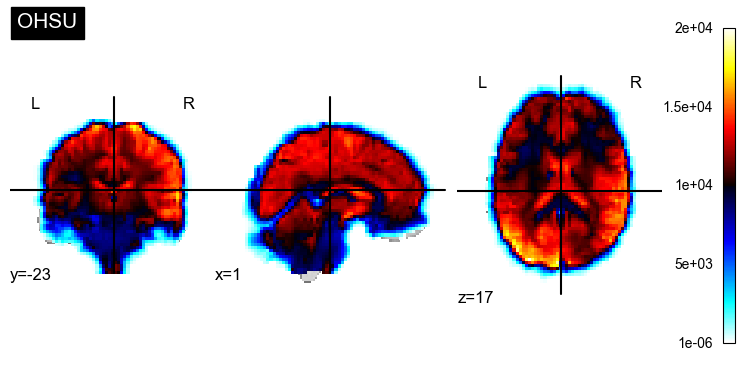

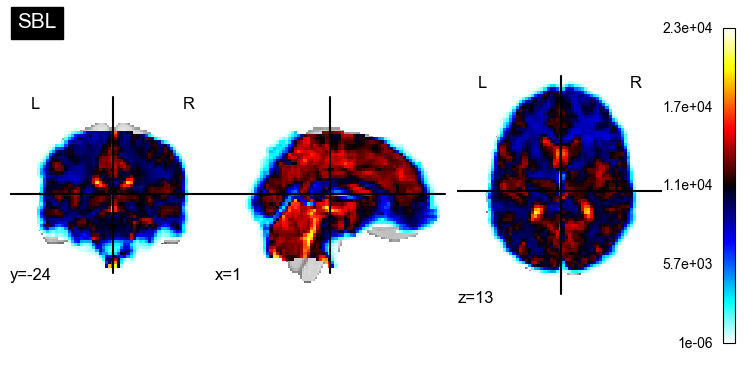

In [144]:
from nilearn import image, plotting
sample_paths = ["/Users/balazsmorvay/Downloads/ABIDE/data/Outputs/ccs/filt_noglobal/func_preproc/OHSU_0050142_func_preproc.nii.gz",
                "/Users/balazsmorvay/Downloads/ABIDE/data/Outputs/ccs/filt_noglobal/func_preproc/SBL_0051557_func_preproc.nii.gz"]
sites
for i, sp in enumerate(sample_paths):
    selected_volumes = image.index_img(sp, slice(3, 4))
    for img in image.iter_img(selected_volumes):
        plotting.plot_stat_map(img, title=sites[i])

In [145]:
Xt1.reshape((Xt1.shape[0], -1)).shape

(18, 20915741)

In [157]:
Xt1=Xt1.reshape((Xt1.shape[0], -1))
Xt2=Xt2.reshape((Xt2.shape[0], -1))

In [158]:
Xt1.shape

(18, 20915741)

In [159]:
Xt1.max(), Xt1.min(), Xt2.max(), Xt2.min()

(21285.078125, -79.40546417236328, 30068.095703125, -60.867454528808594)

In [162]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xt1)
Xt1_scaled = scaler.transform(Xt1)

scaler.fit(Xt2)
Xt2_scaled = scaler.transform(Xt2)

Xt1_scaled.mean(), Xt1_scaled.std(), Xt2_scaled.mean(), Xt2_scaled.std()

(7.805945207108882e-18,
 0.6385404956439367,
 2.5124695201073567e-18,
 0.5832365341657559)

In [182]:
import ot
import numpy as np

ot_sinkhorn = ot.da.SinkhornL1l2Transport()
ot_sinkhorn.fit(Xs=Xt1,
                ys=Yt1,
                Xt=Xt2,
                yt=Yt2,)
Xt1t = ot_sinkhorn.transform(Xs=Xt1.reshape((Xt1.shape[0], -1)))

/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [169]:
Xt1.reshape((Xt1.shape[0], -1)).shape, np.expand_dims(Yt1, axis=1).shape, Xt2.reshape((Xt2.shape[0], -1)).shape, np.expand_dims(Yt2, axis=1).shape

((18, 20915741), (18, 1), (18, 20915741), (18, 1))